# Oxford Pets - Multiclass Segmentation

## Modules

In [1]:
import os
import sys

common_dir = os.path.abspath("../../common")
print(os.listdir(common_dir))

if common_dir not in sys.path:
    sys.path.append(common_dir)

['pt_trainer.py', 'tf_trainer.py', 'utils.py', '__pycache__']


In [2]:
import tensorflow as tf
from tensorflow import keras

import random
import numpy as np
import matplotlib.pyplot as plt

from utils import show_images, plot_progress
from tf_trainer import TrainerWithMetrics, TrainerWithEarlyStopping
from tf_trainer import accuracy, binary_accuracy
from scipy.special import softmax, expit as sigmoid

os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

## Parameters

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
image_size = (224, 224)
batch_size = 32

In [5]:
save_weights = False
weights_name = "./tf_models/tf_oxford-pets_seg-3.h5"

## Data Set

In [6]:
from glob import glob
import re
from sklearn.preprocessing import LabelEncoder
from collections import Counter

def get_paths(image_dir, formats=["*"]):
    invalid_images = ['Egyptian_Mau_14',  'Egyptian_Mau_139', 'Egyptian_Mau_145',
                      'Egyptian_Mau_156', 'Egyptian_Mau_167', 'Egyptian_Mau_177',
                      'Egyptian_Mau_186', 'Egyptian_Mau_191', 'Abyssinian_5',
                      'Abyssinian_34',    'chihuahua_121',    'beagle_116']
    paths = []
    for ext in formats:
        paths += glob(os.path.join(image_dir, f"*.{ext}"))

    valid_paths = []
    for path in paths:
        image_name = os.path.basename(path).split('.')[0]
        if image_name not in invalid_images:
            valid_paths.append(path)
    return valid_paths

def get_labels(image_paths, n_classes=37):
    image_names = [os.path.basename(path).split('.')[0] for path in image_paths]
    if n_classes == 2:
        labels = ['cat' if name[0].isupper() else 'dog' for name in image_names]
    else:
        labels = [re.sub('_\d+', '', name) for name in image_names]
    return labels

def get_class_names(labels):
    return list(Counter(labels).keys())

def label_encoder(labels, class_names):
    encoder = {name: i for i, name in enumerate(class_names)}
    return [encoder[label] for label in labels]

In [8]:
import xml.etree.ElementTree as et

def change_paths(new_dir, old_paths, replace=("ext1", "ext2")):
    filenames = [os.path.basename(path).replace(replace[0], replace[1])
                 for path in old_paths]
    return [os.path.join(new_dir, name) for name in filenames]

def get_bboxes(bbox_paths):
    bboxes = []
    for path in bbox_paths:
        tree = et.parse(path)

        width = float(tree.find('./size/width').text)
        height = float(tree.find('./size/height').text)
        xmin = float(tree.find('./object/bndbox/xmin').text)
        xmax = float(tree.find('./object/bndbox/xmax').text)
        ymin = float(tree.find('./object/bndbox/ymin').text)
        ymax = float(tree.find('./object/bndbox/ymax').text)

        x = (xmax + xmin)/width/2
        y = (ymax + ymin)/height/2
        w = (xmax - xmin)/width
        h = (ymax - ymin)/height
        bboxes.append([x, y, w, h])
    return bboxes

In [9]:
data_dir = "/mnt/f/deep_learning/datasets/oxford_pets_783M/"
image_dir = os.path.join(data_dir, "images")
mask_dir = os.path.join(data_dir, "annotations", "trimaps")

image_paths = get_paths(image_dir, formats=['jpg'])
labels = get_labels(image_paths, n_classes=37)
class_names = get_class_names(labels)
labels = label_encoder(labels, class_names)

print(f">> Images: {len(image_paths)}")
print(">> Class Names:", class_names)

>> Images: 7378
>> Class Names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [10]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, stratify=labels, train_size=0.8, random_state=seed)

train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(
    train_image_paths, train_labels, stratify=train_labels, train_size=0.75, random_state=seed)

train_mask_paths = change_paths(mask_dir, train_image_paths, replace=['jpg', 'png'])
valid_mask_paths = change_paths(mask_dir, valid_image_paths, replace=['jpg', 'png'])
test_mask_paths = change_paths(mask_dir, test_image_paths, replace=['jpg', 'png'])

n_images = len(image_paths)
print(f">> Train images: {len(train_image_paths)} ({len(train_image_paths)/n_images:.2f})")
print(f">> Valid images: {len(valid_image_paths)} ({len(valid_image_paths)/n_images:.2f})")
print(f">> Test  images: {len(test_image_paths)} ({len(test_image_paths)/n_images:.2f})")

>> Train images: 4426 (0.60)
>> Valid images: 1476 (0.20)
>> Test  images: 1476 (0.20)


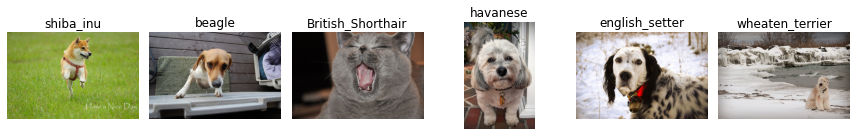

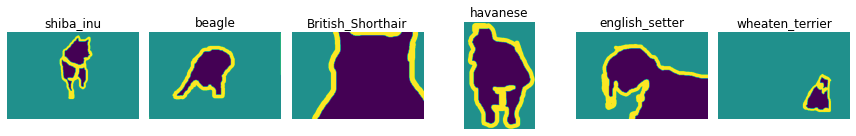

In [12]:
n_samples = 6
show_images(train_image_paths[:n_samples], labels=train_labels[:n_samples], 
            class_names=class_names, n_cols=6)
show_images(train_mask_paths[:n_samples], labels=train_labels[:n_samples], 
            class_names=class_names, n_cols=6)

## Data Loader

In [13]:
import albumentations as A
from functools import partial

@tf.function
def load_data(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=1)
    return image, mask

def augmenation(image, mask, training):
    transform = train_transform if training else valid_transform
    transformed = transform(image=image, mask=mask)
    image = transformed['image']
    mask = transformed['mask']

    # image = tf.cast(image, dtype=tf.float32)/255
    image = tf.cast(image, dtype=tf.float32)
    mask -= 1
    mask = tf.cast(mask, dtype=tf.int64)
    return image, mask

@tf.function
def preprocess(image, mask, training):
    image, mask = tf.numpy_function(augmenation,
                        inp=[image, mask, training],
                        Tout=[tf.float32, tf.int64])
    return image, mask

def get_dataloader(image_paths, mask_paths, batch_size, training, shuffle=True):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    dataloader = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths)).cache()
    dataloader = dataloader.map(load_data, num_parallel_calls=AUTOTUNE)
    dataloader = dataloader.map(partial(preprocess, training=training),
                                num_parallel_calls=AUTOTUNE)
    if shuffle:
        dataloader = dataloader.shuffle(1000)
    dataloader = dataloader.batch(batch_size).prefetch(AUTOTUNE)
    return dataloader

train_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5, shift_limit=0.05, scale_limit=0.05, 
                       rotate_limit=15,),
    # A.CoarseDropout(p=0.5, max_holes=8, max_height=int(0.1*image_size[0]), 
    #                 max_width=int(0.1*image_size[1])),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

valid_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

train_loader = get_dataloader(train_image_paths, train_mask_paths, 
                              batch_size, training=True, shuffle=True)
valid_loader = get_dataloader(valid_image_paths, valid_mask_paths,
                              batch_size, training=False, shuffle=False)
test_loader = get_dataloader(test_image_paths, test_mask_paths,
                             batch_size, training=False, shuffle=False)

<class 'tensorflow.python.framework.ops.EagerTensor'> (32, 224, 224, 3) <dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'> (32, 224, 224, 1) <dtype: 'int64'>
>> Images: min: 0, max: 255
>> Masks:  min: 0, max: 2


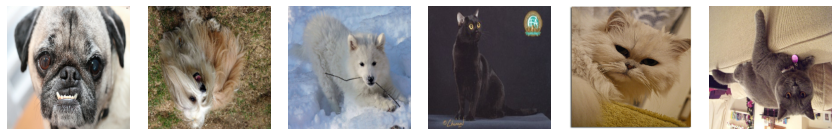

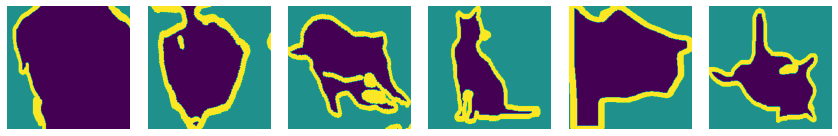

In [16]:
images, masks = next(iter(train_loader))
print(type(images), images.shape, images.dtype)
print(type(masks), masks.shape, masks.dtype)

images = images.numpy().astype(int)
masks = masks.numpy()

n_samples = 6
print(f">> Images: min: {images.min()}, max: {images.max()}")
print(f">> Masks:  min: {masks.min()}, max: {masks.max()}")
show_images(images[:n_samples], n_cols=6)
show_images(masks[:n_samples], n_cols=6)

### Modeling

In [17]:
import segmentation_models as sm

model = sm.Unet('mobilenetv2', encoder_weights='imagenet',
                input_shape=(224, 224, 3), classes=3,
                activation=None)

Segmentation Models: using `keras` framework.


In [22]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(input_shape, n_classes):
    inputs = keras.Input(input_shape)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(n_classes, 3, padding="same")(x)

    return keras.Model(inputs, outputs)

## Training

In [24]:
%%time
keras.backend.clear_session()

model = get_model(input_shape=(224, 224, 3), n_classes=3)
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_fn = keras.metrics.sparse_categorical_accuracy

model.compile(optimizer=optimizer, loss=loss_fn, metrics=metric_fn)
model.fit(train_loader, epochs=1, validation_data=valid_loader)

TypeError: in user code:

    File "/home/nam/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/nam/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nam/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/nam/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 894, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/nam/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 987, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/nam/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 501, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/nam/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/nam/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/nam/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 646, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/nam/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/metrics/metrics.py", line 3330, in sparse_categorical_accuracy
        if matches.shape.ndims > 1 and matches.shape[-1] == 1:

    TypeError: '>' not supported between instances of 'NoneType' and 'int'


In [21]:
# %%time
# ## Feature Extraction

# model = sm.Unet('mobilenetv2', encoder_weights='imagenet',
#                 input_shape=(224, 224, 3), classes=3,
#                 activation='softmax')
# optimizer = keras.optimizers.Adam()
# # loss_fn = sm.losses.DiceLoss()
# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# # metrics = {'iou': sm.metrics.IOUScore(threshold=0.5)}
# metrics = {'acc': accuracy}

# clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
# hist = clf.fit(train_loader, n_epochs=100, valid_loader=valid_loader)

# results = clf.evaluate(test_loader)
# print(">>", ', '.join([f"test_{key}={value:.4f}" 
#                        for key, value in results.items()]))

  0%|                                                                       | 0/139 [00:00<?, ?it/s]

/home/nam/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


ValueError: in user code:

    File "/mnt/f/deep_learning/common/tf_trainer.py", line 201, in train_step  *
        results[metric_name] = float(metric_fn(y, pred))
    File "/mnt/f/deep_learning/common/tf_trainer.py", line 21, in accuracy  *
        return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

    ValueError: Dimensions must be equal, but are 224 and 32 for '{{node Equal}} = Equal[T=DT_INT64, incompatible_shape_error=true](y_true, ArgMax)' with input shapes: [32,224,224,1], [32,224,224].


In [16]:
%%time
## Fine Tuneing

model.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-5)
clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
hist = clf.fit(train_loader, n_epochs=100, valid_loader=valid_loader)

results = clf.evaluate(test_loader)
print(">>", ', '.join([f"test_{key}={value:.4f}" 
                       for key, value in results.items()]))

Epoch[  1/100] loss=0.6185, mse=0.0364, ce=0.5821, iou=0.2538, acc=0.8330 | val_loss=0.4025, val_mse=0.0288, val_ce=0.3737, val_iou=0.3352, val_acc=0.8958 (1)
Epoch[  2/100] loss=0.4530, mse=0.0308, ce=0.4222, iou=0.2751, acc=0.8741 | val_loss=0.4040, val_mse=0.0276, val_ce=0.3764, val_iou=0.3425, val_acc=0.8919 (2)
Epoch[  3/100] loss=0.4380, mse=0.0312, ce=0.4068, iou=0.2855, acc=0.8643 | val_loss=0.4057, val_mse=0.0252, val_ce=0.3805, val_iou=0.3436, val_acc=0.8958 (3)
Epoch[  4/100] loss=0.4001, mse=0.0305, ce=0.3695, iou=0.2926, acc=0.8969 | val_loss=0.4082, val_mse=0.0247, val_ce=0.3835, val_iou=0.3466, val_acc=0.8971 (4)
Epoch[  5/100] loss=0.3750, mse=0.0320, ce=0.3430, iou=0.3051, acc=0.9161 | val_loss=0.4067, val_mse=0.0234, val_ce=0.3833, val_iou=0.3506, val_acc=0.8945 (5)
>> Early stopped! (Best epoch=1)
>> test_loss=0.3394, test_mse=0.0281, test_ce=0.3112, test_iou=0.3363, test_acc=0.8919              
CPU times: user 2min 44s, sys: 35.4 s, total: 3min 20s
Wall time: 1min 

In [18]:
clf = TrainerWithMetrics(model, optimizer, loss_fn, metrics)
hist = clf.fit(valid_loader, n_epochs=3)

results = clf.evaluate(test_loader)
print(">>", ', '.join([f"test_{key}={value:.4f}" 
                       for key, value in results.items()]))

Epoch[  1/  3] loss=0.9106, mse=0.0374, ce=0.8732, iou=0.2230, acc=0.7513                           
Epoch[  2/  3] loss=0.6984, mse=0.0336, ce=0.6649, iou=0.2365, acc=0.8229                           
Epoch[  3/  3] loss=0.5496, mse=0.0307, ce=0.5188, iou=0.2487, acc=0.8607                           
>> test_loss=0.3296, test_mse=0.0254, test_ce=0.3042, test_iou=0.3344, test_acc=0.8906              


In [ ]:
if save_weights:
    model.save_weights(weights_name)

## Inference

In [ ]:
if save_weights:
    model = get_pretrained_model('efficientnetv2', input_shape=(224, 224, 3), n_classes=4+37, freezed=True)
    model.load_weights(weights_name)

1/1 [==============================] - 0s 26ms/step
>> Ground Truth:


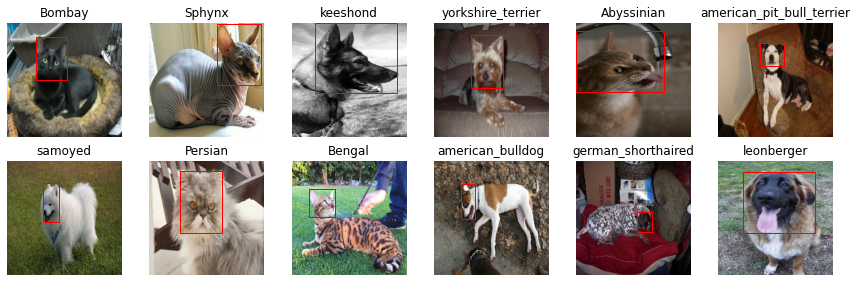

>> Predictions:


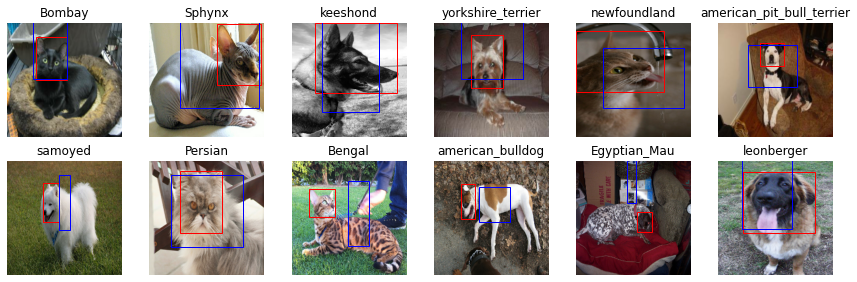

In [25]:
images, bboxes_labels = next(iter(test_loader))
preds = model.predict(images)

images = images.numpy().astype(int)
bboxes_labels = bboxes_labels.numpy()
bboxes, labels = bboxes_labels[:, :4], bboxes_labels[:, 4:]
pred_bboxes, pred_labels = preds[:, :4], preds[:, 4:].argmax(axis=-1)

n_samples = 12
print(f">> Ground Truth:")
show_images(images[:n_samples], labels=labels[:n_samples], class_names=class_names,
            bboxes=bboxes[:n_samples], n_cols=6)

print(f">> Predictions:")
show_images(images[:n_samples], labels=pred_labels[:n_samples], class_names=class_names,
            bboxes=bboxes[:n_samples], 
            bboxes2=pred_bboxes[:n_samples], bbox_color2='b', n_cols=6)